# Boilerplate

Packae installation, loading, and dataloaders. There's also a simple model defined. You can change it your favourite architecture if you want.

In [19]:
!pip install tensorboardX

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time

from torchvision import datasets, transforms
from tensorboardX import SummaryWriter

In [114]:
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 64

np.random.seed(42)
torch.manual_seed(42)


## Dataloaders
train_dataset = datasets.MNIST('mnist_data/', train=True, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))
test_dataset = datasets.MNIST('mnist_data/', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Simple NN. You can change this if you want.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(28*28, 200)
        self.fc2 = nn.Linear(200,10)

    def forward(self, x):
        x = x.view((-1, 28*28))
        x = F.relu(self.fc(x))
        x = self.fc2(x)
        return x

class Normalize(nn.Module):
    def forward(self, x):
        return (x - 0.1307)/0.3081

# Add the data normalization as a first "layer" to the network
# this allows us to search for adverserial examples to the real image, rather than
# to the normalized image
model_raw = nn.Sequential(Normalize(), Net())

model_raw = model_raw.to(device)

Text(0.5, 1.0, '5')

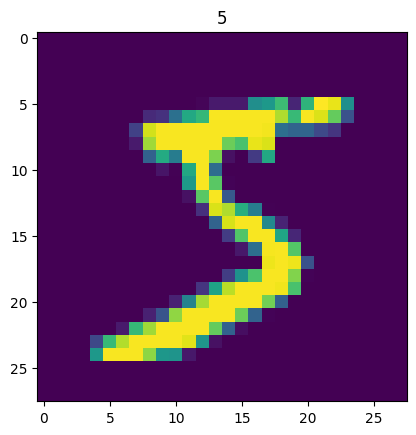

In [115]:
import matplotlib.pyplot as plt
plt.imshow(train_dataset[0][0][0])
plt.title(train_dataset[0][1])

# Implement the Attacks

Functions are given a simple useful signature that you can start with. Feel free to extend the signature as you see fit.

You may find it useful to create a 'batched' version of PGD that you can use to create the adversarial attack.

In [116]:
# The last argument 'targeted' can be used to toggle between a targeted and untargeted attack.
def fgsm(model, x, target, eps, targeted=True):
  x.requires_grad_()
  L = nn.CrossEntropyLoss()
  eps_new = eps - 1e-7
  loss = L(model(x), target)
  loss.backward()
  if targeted:
    x = x - eps_new * x.grad.sign()
  else:
    x = x + eps_new * x.grad.sign()
  x = x.clamp(*(0, 1))
  return x

def pgd_untargeted(model, x, labels, eps, eps_step, num_itr=30):
  x_new = x.clone().requires_grad_(True)
  L = nn.CrossEntropyLoss()

  for i in range(num_itr):
    x_new = x_new.clone().detach().requires_grad_(True)
    loss = L(model(x_new), labels)
    loss.backward()
    with torch.no_grad():
      x_new = x_new + x_new.grad.sign() * eps_step
    x_new = torch.clamp(x_new, x - eps, x + eps)
    x_new = x_new.clamp(*(0, 1))
  return x_new.detach()

# Implement Adversarial Training

In [117]:
def train_model(model, num_epochs, enable_defense=True):
    model.train()
    learning_rate = 0.0001

    opt = optim.Adam(params=model.parameters(), lr=learning_rate)

    ce_loss = torch.nn.CrossEntropyLoss()

    tot_steps = 0

    for epoch in range(1,num_epochs+1):
        t1 = time.time()
        for batch_idx, (x_batch, y_batch) in enumerate(train_loader):

            if enable_defense:
                pass
                ###############################################
                # Fill code here to do adversarial training
                # You may find it useful to switch to 'eval' model while generating the attack
                # and switch back again to 'train' mode once the attack is generated.
                ###############################################
                # pgd_untargeted(model, x, labels, k, eps, eps_step, num_itr=30)
                x_batch = pgd_untargeted(model, x_batch, y_batch, 20.0/256, 1.0/256)

            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            tot_steps += 1
            opt.zero_grad()
            out = model(x_batch)
            batch_loss = ce_loss(out, y_batch)
            batch_loss.backward()
            opt.step()

        tot_test, tot_acc = 0.0, 0.0
        for batch_idx, (x_batch, y_batch) in enumerate(test_loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            out = model(x_batch)
            pred = torch.max(out, dim=1)[1]
            acc = pred.eq(y_batch).sum().item()
            tot_acc += acc
            tot_test += x_batch.size()[0]
        t2 = time.time()

        print('Epoch %d: Accuracy %.5lf [%.2lf seconds]' % (epoch, tot_acc/tot_test, t2-t1))
    return model

In [119]:
model_basic = train_model(model_raw, 10, enable_defense=False)

Epoch 1: Accuracy 0.91860 [8.81 seconds]
Epoch 2: Accuracy 0.93760 [8.55 seconds]
Epoch 3: Accuracy 0.94750 [8.82 seconds]
Epoch 4: Accuracy 0.95410 [8.83 seconds]
Epoch 5: Accuracy 0.96050 [8.93 seconds]
Epoch 6: Accuracy 0.96290 [8.46 seconds]
Epoch 7: Accuracy 0.96800 [10.54 seconds]
Epoch 8: Accuracy 0.96890 [11.23 seconds]
Epoch 9: Accuracy 0.97170 [8.90 seconds]
Epoch 10: Accuracy 0.97240 [8.92 seconds]


# Study Accuracy, Quality, etc.

Compare the various results and report your observations on the submission.

In [120]:
# FGSM untargeted attack
def eval_acc(model, type_att=0):
  types = ["FGSM untargeted", "FGSM targeted", "PGD"]
  total = 0
  correct_normal = 0
  correct_attack = 0
  model.eval()

  for x, y in test_loader:
    out_norm = model(x)

    new_x = x
    if type_att%3 == 0:
      new_x = fgsm(model, x, y, 20.0/256, targeted=False)
    elif type_att%3 == 1:
      new_x = fgsm(model, x, (y+3)%10, 20.0/256, targeted=True)
    else:
      new_x = pgd_untargeted(model, x, y, 20.0/256, 1.0/256)

    out_attack = model(new_x)

    pred_norm = out_norm.argmax(dim=1)
    pred_attack = out_attack.argmax(dim=1)

    correct_normal += sum([y[i] == pred_norm[i] for i in range(len(pred_norm))])
    correct_attack += sum([y[i] == pred_attack[i] for i in range(len(pred_attack))])
    total += len(y)

  print("Model accuracy on original dataset: ", correct_normal / total)

  print("Model accuracy after ", types[type_att%3], " attack: ", correct_attack / total)

In [121]:
eval_acc(model_basic, type_att=0)

Model accuracy on original dataset:  tensor(0.9724)
Model accuracy after  FGSM untargeted  attack:  tensor(0.4320)


In [122]:
eval_acc(model_basic, type_att=1)

Model accuracy on original dataset:  tensor(0.9724)
Model accuracy after  FGSM targeted  attack:  tensor(0.7580)


In [123]:
eval_acc(model_basic, type_att=2)

Model accuracy on original dataset:  tensor(0.9724)
Model accuracy after  PGD  attack:  tensor(0.3626)


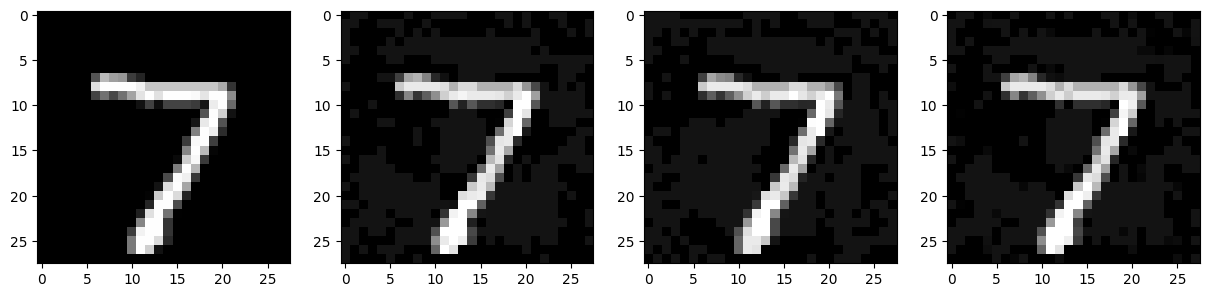

In [124]:
x, y = next(iter(test_loader))

x_fgsm_targeted = fgsm(model_basic, x, y, 20.0/256, targeted=False)
x_fgsm_untargeted_features = fgsm(model_basic, x, (y+3)%10, 20.0/256, targeted=True)
x_pgd_features = pgd_untargeted(model_basic, x, y, 20.0/256, 1.0/256)

fig, axs = plt.subplots(1, 4, figsize=(15, 60))
axs[0].imshow(x.detach().numpy()[0][0], cmap='gray')
axs[1].imshow(x_fgsm_targeted.detach().numpy()[0][0], cmap='gray')
axs[2].imshow(x_fgsm_untargeted_features.detach().numpy()[0][0], cmap='gray')
axs[3].imshow(x_pgd_features.detach().numpy()[0][0], cmap='gray')

## PGD Training

In [98]:
model_adv = train_model(model_raw, 5, enable_defense=True)

Epoch 1: Accuracy 0.96880 [48.47 seconds]
Epoch 2: Accuracy 0.96950 [47.16 seconds]
Epoch 3: Accuracy 0.97260 [51.57 seconds]
Epoch 4: Accuracy 0.97380 [47.23 seconds]
Epoch 5: Accuracy 0.97500 [47.06 seconds]


In [125]:
eval_acc(model_adv, type_att=0)

Model accuracy on original dataset:  tensor(0.9765)
Model accuracy after  FGSM untargeted  attack:  tensor(0.8848)


In [126]:
eval_acc(model_adv, type_att=1)

Model accuracy on original dataset:  tensor(0.9765)
Model accuracy after  FGSM targeted  attack:  tensor(0.9497)


In [127]:
eval_acc(model_adv, type_att=2)

Model accuracy on original dataset:  tensor(0.9765)
Model accuracy after  PGD  attack:  tensor(0.8761)
